In [1]:
import tfscreen
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## tfscreen walkthrough

This notebook walks through the tfscreen simulation and analysis pipeline. It assumes that you downloaded the tfscreen [repo](https://github.com/harmslab/tfscreen) and that you installed the libray by running "`pip install .`" inside the base tfscreen directory. 


### Simulation inputs

+ **run_config.yaml**: A text file that defines the simulation parameters. It has comments throughout that explain what the different parameters are.
+ **ddG.xslx**: A spreadsheet with the effects of all mutations on each of the conformations in the ensemble selected in the run configuration. The path to this file (and its filename) are defined *in* run_config.yaml.
+ **calibration.json**: A json file that describes the linking function between fractional occupancy and growth rate under the conditions specified in the run_config. The path to this file (and its filename) are defined *in* run_config.yaml.

### Run the simulation

Simulate transformation, growth, and sequencing. This yields six dataframes:
+ `growth_df`: This exactly matches the final output of a processed experiment and can be used as input in all downstream analyses. 
+ `sample_df`: The conditions of each multiplexed sample sent in for "sequencing"
+ `counts_df`: The counts for each genotype under each condition. This also has the true parameters used in the generating model (`dk_geno`, `theta`, and `ln_cfu0`) so we can check to see how well our model is extracting these parameters. 
+ `library_df`: The genotypes in the library and their true frequencies.
+ `phenotype_df`: The calculated phenotypes of each genotype.
+ `genotype_ddG_df`: The effect of mutations on the energy of each conformation in the ensemble. 

In [2]:

# Read the yaml file defining the library, thermodynamic, and simulation 
# parameters. The `override_keys` dictionary lets you override keys in the 
# .yaml file without having to edit the file every time. We're going to run
# the simulation with a multi-transformation lamba of 2.5.
override_keys = {"transformation_poisson_lambda":2.5}
cf = tfscreen.util.read_yaml("run_config.yaml",override_keys)

# Make a dataframe holding the library contents (library_df), a dataframe
# with phenotypes, and a dataframe of genotype ddG per conformation. 
library_df, phenotype_df, genotype_ddG_df = tfscreen.simulate.library_prediction(cf)

# Simulate a selection experiment. This generates a sample_df and counts_df
# exactly equivalent to experimental outputs. 
sample_df, counts_df = tfscreen.simulate.selection_experiment(cf,library_df,phenotype_df)

# Build a growth_df from the sample and counts dataframe (just like an
# experiment). This `growth_df` is the input to either an independent 
# (maximum likelihood) analysis or a hierarchical (Bayesian) analysis. 
growth_df = tfscreen.process_raw.counts_to_lncfu(sample_df,counts_df)
growth_df


Initializing phenotype calculation... Done.


calculating theta using thermo model:   0%|          | 0/844 [00:00<?, ?it/s]

Calculating growth rates and building final dataframe... Done.
Setting up calculation.
Simulating growth and sequencing


replicate/library:   0%|          | 0/2 [00:00<?, ?it/s]

--> simulating transformation
--> simulating growth
--> simulating sequencing
--> simulating index hopping
--> simulating transformation
--> simulating growth
--> simulating sequencing
--> simulating index hopping
Generating final dataframe.
Simulation complete.


,sample,genotype,dk_geno,k_pre,k_sel,theta,ln_cfu_0,counts,titrant_name,titrant_conc,...,replicate,library,sample_cfu,sample_cfu_std,adjusted_counts,frequency,cfu,cfu_var,ln_cfu_var,ln_cfu
0,0,wt,0.000000,0.005401,-0.008989,0.904963,12.257865,2415,iptg,0.0,...,1,kanR,4.556689e+06,2.278344e+05,2416,0.005785,26361.251870,2.023256e+06,0.002912,10.179650
1,1,wt,0.000000,0.005401,-0.008989,0.904963,12.257865,2495,iptg,0.0,...,1,kanR,3.501348e+06,1.750674e+05,2496,0.005981,20940.232996,1.270861e+06,0.002898,9.949428
2,2,wt,0.000000,0.005401,-0.008989,0.904963,12.257865,2667,iptg,0.0,...,1,kanR,2.701849e+06,1.350925e+05,2668,0.006387,17255.907102,8.553096e+05,0.002872,9.755910
3,3,wt,0.000000,0.005401,0.005401,0.904963,12.257865,1925,iptg,0.0,...,1,kanR,3.841861e+07,1.920931e+06,1926,0.004614,177272.504320,9.480504e+07,0.003017,12.085443
4,4,wt,0.000000,0.005401,0.005401,0.904963,12.257865,2193,iptg,0.0,...,1,kanR,3.647013e+07,1.823506e+06,2194,0.005259,191790.234978,1.086361e+08,0.002953,12.164158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50635,55,M42I/H74A/K84L,-0.007982,0.009813,0.003975,0.195360,3.063316,18,iptg,1.0,...,1,pheS,2.064961e+08,1.032481e+07,19,0.000046,9401.054399,4.872307e+06,0.055129,9.148577
50636,56,M42I/H74A/K84L,-0.007982,0.009813,0.003975,0.195360,3.063316,22,iptg,1.0,...,1,pheS,2.309038e+08,1.154519e+07,23,0.000055,12722.156798,7.441344e+06,0.045976,9.451100
50637,57,M42I/H74A/K84L,-0.007982,0.009813,0.009813,0.195360,3.063316,30,iptg,1.0,...,1,pheS,2.836462e+08,1.418231e+07,31,0.000074,21050.110984,1.540049e+07,0.034756,9.954661
50638,58,M42I/H74A/K84L,-0.007982,0.009813,0.009813,0.195360,3.063316,20,iptg,1.0,...,1,pheS,3.503815e+08,1.751907e+07,21,0.000050,17621.487131,1.556206e+07,0.050117,9.776874


#### Run the fit

This does a maximum-likelihood fit on each genotype individually. The outputs are:
+ `param_df`: holds all fit parameters
+ `pred_df`: holds all predicted ln_cfu values at all conditions
+ `results`: a dictionary that holds dataframes organized by parameter type (`theta`, `dk_geno`, `ln_cfu0`, and `pred`). 

In [3]:
# Fit for theta. We use the same calibration file we used to simulate the 
# data, so whatever differences we see are because of the experiment and/or
# analysis, not an incorrect growth model. 
param_df, pred_df = tfscreen.analysis.independent.cfu_to_theta(growth_df,
                                                               calibration_data=cf["calibration_file"],
                                                               non_sel_conditions=["kanR-kan","pheS-4CP"])

# Helper function generates clean versions of output. Because our counts_df 
# has the known, real answers, these are also loaded into the results. 
results = tfscreen.analysis.independent.process_theta_fit(param_df,
                                                          pred_df,
                                                          counts_df,
                                                          sample_df)

print("dataframes generated:",list(results.keys()))
results["theta"]

  0%|          | 0/211 [00:00<?, ?it/s]

dataframes generated: ['theta', 'dk_geno', 'ln_cfu0', 'pred']


,genotype,titrant_name,titrant_conc,theta_est,theta_std,theta_real,class,name,guess,transform,scale_mu,scale_sigma,idx,lower_bounds,upper_bounds,censored,fixed
0,wt,iptg,0.0000,0.895655,0.017076,0.904963,theta,theta_wt_iptg_0.0,1.000000,logistic,0.0,1.0,12,-inf,inf,False,False
1,wt,iptg,0.0001,0.892171,0.017305,0.904241,theta,theta_wt_iptg_0.0001,0.999960,logistic,0.0,1.0,13,-inf,inf,False,False
2,wt,iptg,0.0010,0.887008,0.017303,0.894721,theta,theta_wt_iptg_0.001,0.996037,logistic,0.0,1.0,14,-inf,inf,False,False
3,wt,iptg,0.0030,0.842620,0.017293,0.857611,theta,theta_wt_iptg_0.003,0.965431,logistic,0.0,1.0,15,-inf,inf,False,False
4,wt,iptg,0.0100,0.679170,0.017382,0.663455,theta,theta_wt_iptg_0.01,0.715383,logistic,0.0,1.0,16,-inf,inf,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6747,M42I/H74A/K84L,iptg,0.0030,0.749956,0.090510,0.900885,theta,theta_M42I/H74A/K84L_iptg_0.003,0.965431,logistic,0.0,1.0,39,-inf,inf,False,False
6748,M42I/H74A/K84L,iptg,0.0100,0.636204,0.089742,0.860045,theta,theta_M42I/H74A/K84L_iptg_0.01,0.715383,logistic,0.0,1.0,40,-inf,inf,False,False
6749,M42I/H74A/K84L,iptg,0.0300,0.353692,0.090504,0.707266,theta,theta_M42I/H74A/K84L_iptg_0.03,0.218308,logistic,0.0,1.0,41,-inf,inf,False,False
6750,M42I/H74A/K84L,iptg,0.1000,0.189968,0.090724,0.405467,theta,theta_M42I/H74A/K84L_iptg_0.1,0.024519,logistic,0.0,1.0,42,-inf,inf,False,False


#### Compare estimated to real parameter values.

Since we simulated the dataset, we know the underlying growth parameters. We can thus ask how good we are at extracting these known values. The following code generates plots to help us analyze the results and spits out some statistics on the fit quality. Some things to look for:

1. **Correlation**: is there a strong correlation between the estimated and real k values? This can be evaluated in the in the plot on the left, as well as in the $R^2$ value in the stats output. 
2. **RMSE**: How wrong are we, on average? This is in the stats output. 
3. **Calibration**: Do our parameter uncertainty values capture the true error in our estimates? If yes, the red line on the right plot will exactly match the gray histogram. The test statistic "coverage probability" will also be 0.95. This measures the fraction of (predicted - real) parameters that land within their inferred 95% confidence intervals. If the value is *lower* than 0.95, it means that our errors are too small; if the value is *greater* than 0.95, it means our errors are too large. 

Fit statistics for theta:
pct_success: 1.0
rmse: 0.20165459067672767
normalized_rmse: 0.2274580466587717
pearson_r: 0.8701478292852807
r_squared: 0.757157244809886
mean_error: 0.12239121836323766
coverage_prob: 0.37855450236966826
residual_corr: -0.5497447543198155
residual_corr_p_value: 0.0
bp_p_value: 2.589560053413587e-197

Fit statistics for ln_cfu0:
pct_success: 1.0
rmse: 0.6441788641986124
normalized_rmse: 0.10308254402732354
pearson_r: 0.9242514951524088
r_squared: 0.8542408262914631
mean_error: 0.06728022306981744
coverage_prob: 0.22511848341232227
residual_corr: -0.6451144866477925
residual_corr_p_value: 2.858891213245997e-199
bp_p_value: 1.6997399137913308e-76

Fit statistics for dk_geno:
pct_success: 1.0
rmse: 0.004063082436920862
normalized_rmse: 0.23184232954583783
pearson_r: 0.7787717916628737
r_squared: 0.6064855034898023
mean_error: 0.0022521884739064428
coverage_prob: 0.33649289099526064
residual_corr: -0.9426169931672715
residual_corr_p_value: 0.0
bp_p_value: 3.608446

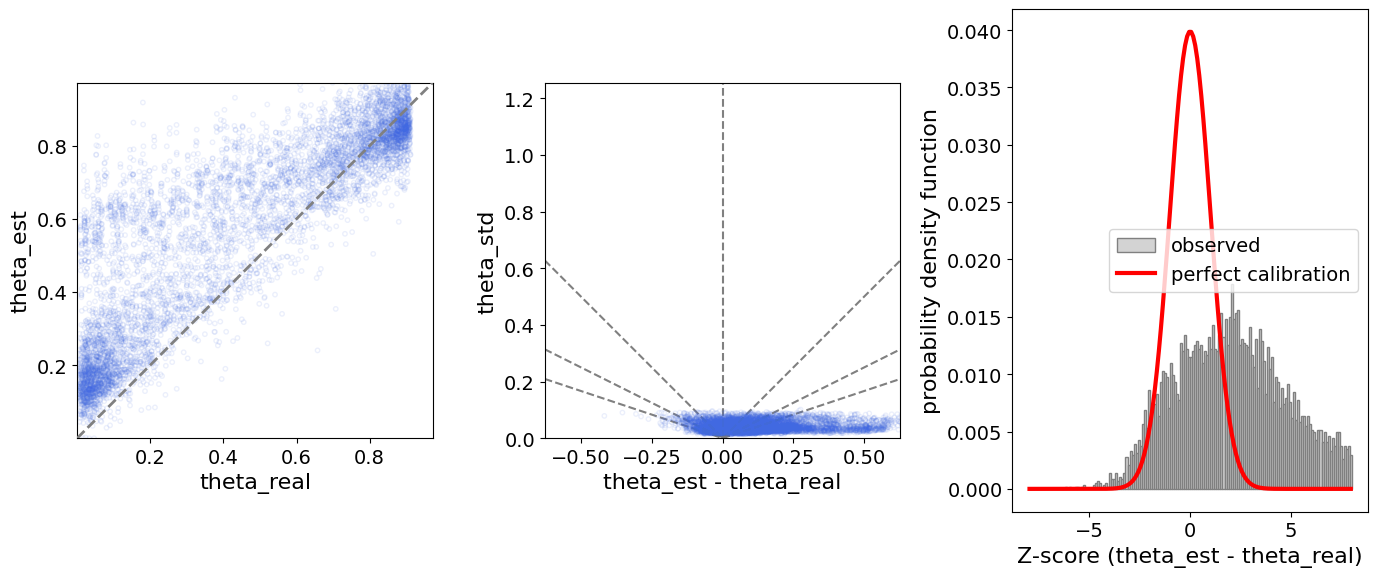

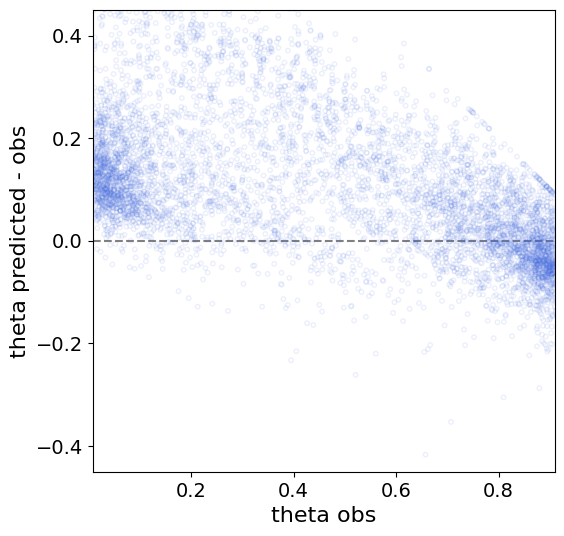

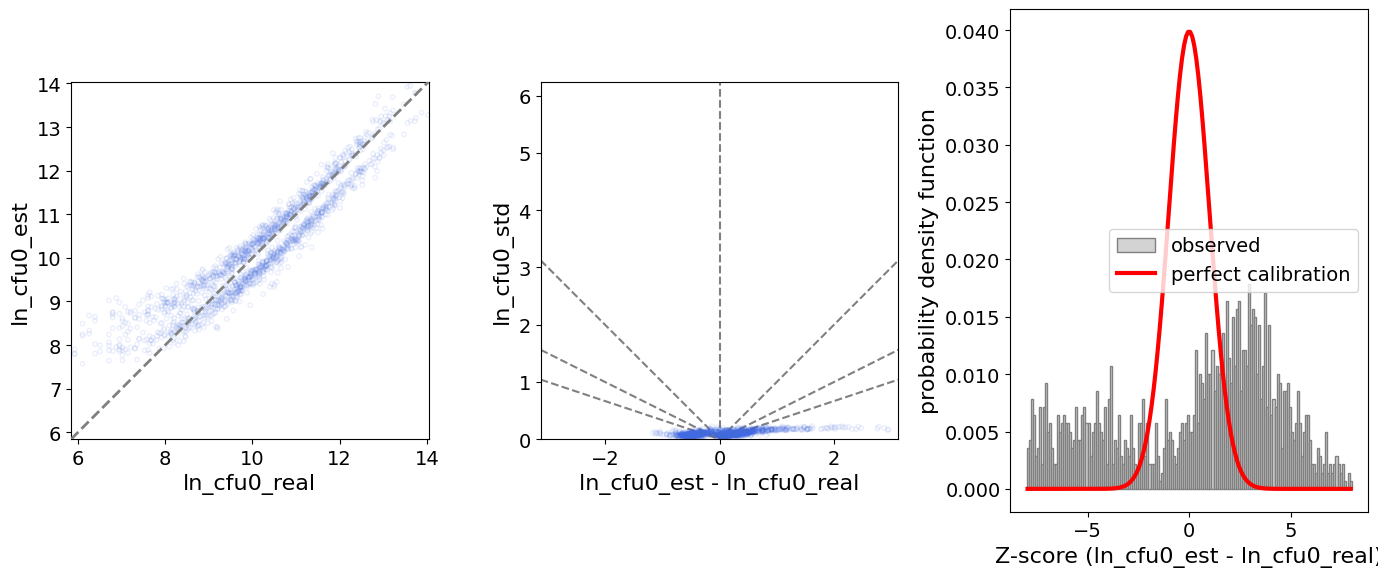

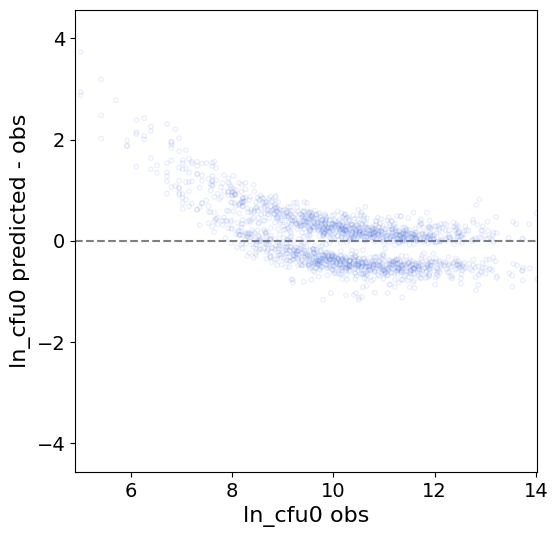

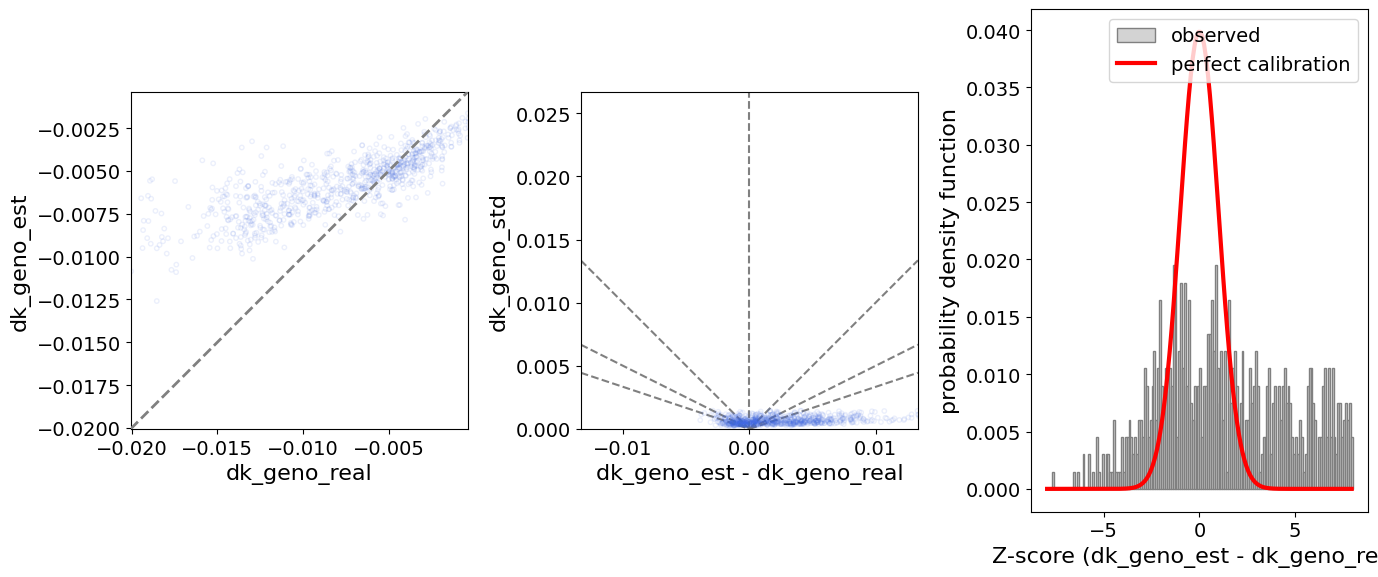

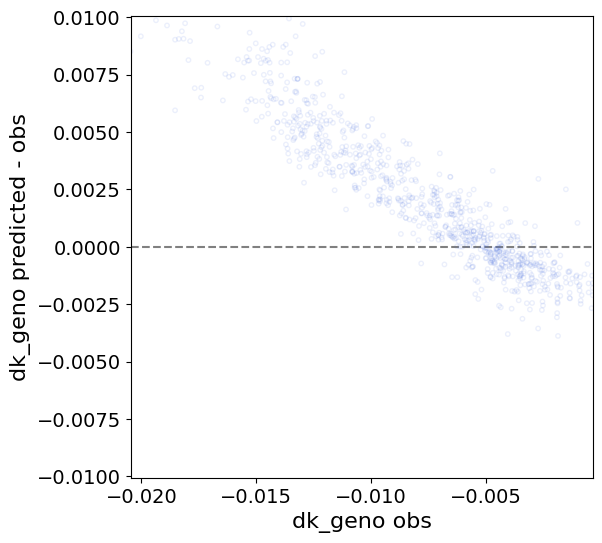

In [4]:

params = ["theta","ln_cfu0","dk_geno"]

for p in params:

    result_df = results[p]
    fig, ax = tfscreen.plot.est_v_real_summary(result_df[f"{p}_est"],
                                               result_df[f"{p}_std"],
                                               result_df[f"{p}_real"],
                                               axis_prefix=p)
    
    ax = tfscreen.plot.err_vs_mag(result_df[f"{p}_real"],
                                  result_df[f"{p}_est"],axis_name=p) 

    stats = tfscreen.fitting.stats_test_suite(result_df[f"{p}_est"],
                                              result_df[f"{p}_std"],
                                              result_df[f"{p}_real"])
    print(f"Fit statistics for {p}:")
    for s in stats:
        print(f"{s}: {stats[s]}")
    print()

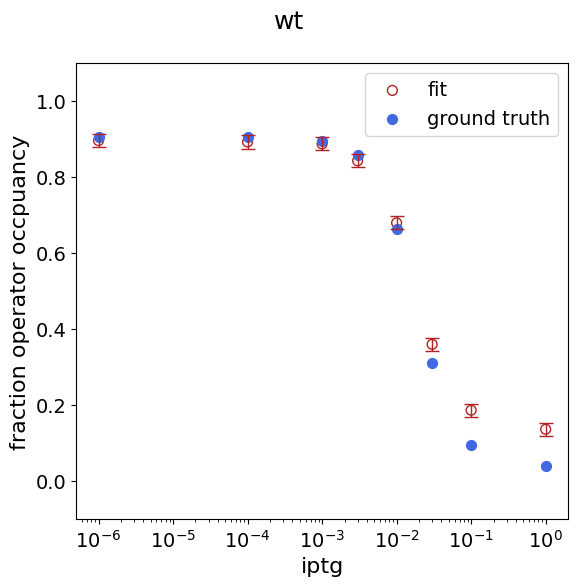

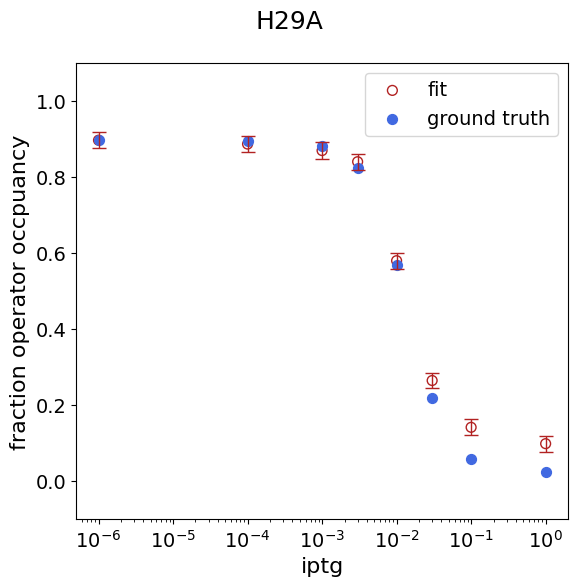

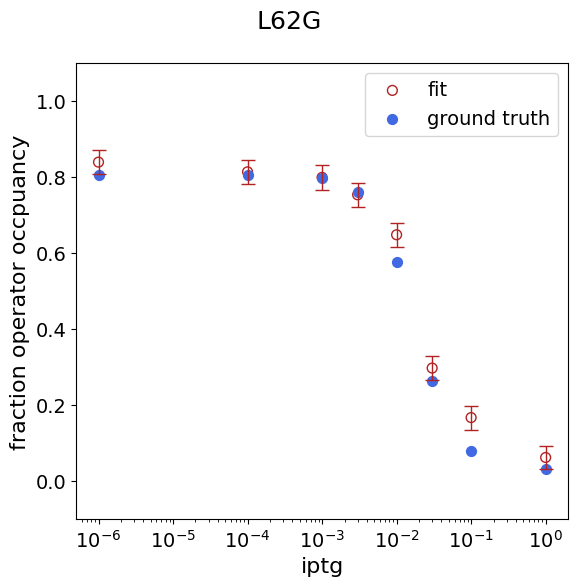

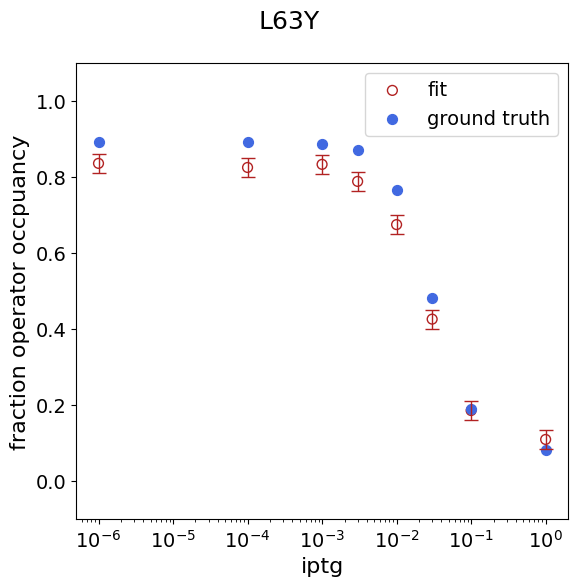

In [5]:

def plot_single_genotype(genotype,theta_df):

    this_output_df = theta_df.loc[theta_df["genotype"] == genotype,:].copy()
    this_output_df.loc[this_output_df["titrant_conc"] == 0,"titrant_conc"] = 1e-6
    
    fig, ax = plt.subplots(1,figsize=(6,6))
    
    ax.errorbar(this_output_df["titrant_conc"],
                this_output_df["theta_est"],
                yerr=this_output_df["theta_std"],
                lw=0,
                elinewidth=1,
                capsize=5,
                color='firebrick')
    ax.scatter(this_output_df["titrant_conc"],
               this_output_df["theta_est"],
               s=50,
               edgecolor='firebrick',
               facecolor="none",
               label="fit")
    ax.scatter(this_output_df["titrant_conc"],
               this_output_df["theta_real"],
               s=50,
               color='royalblue',
               label="ground truth")
    
    ax.legend()

    fig.suptitle(genotype)
    ax.set_xscale("log")
    ax.set_ylim(-0.1,1.1)
    ax.set_xlabel("iptg")
    ax.set_ylabel("fraction operator occpuancy")
    fig.tight_layout()
    
    return fig, ax


theta_df = results["theta"]


_ = plot_single_genotype("wt",theta_df)
_ = plot_single_genotype("H29A",theta_df)
_ = plot_single_genotype("L62G",theta_df)
_ = plot_single_genotype("L63Y",theta_df)